<a href="https://colab.research.google.com/github/sekarch/LoRa/blob/master/Quality_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install trimesh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 6.2 MB/s eta 0:00:00


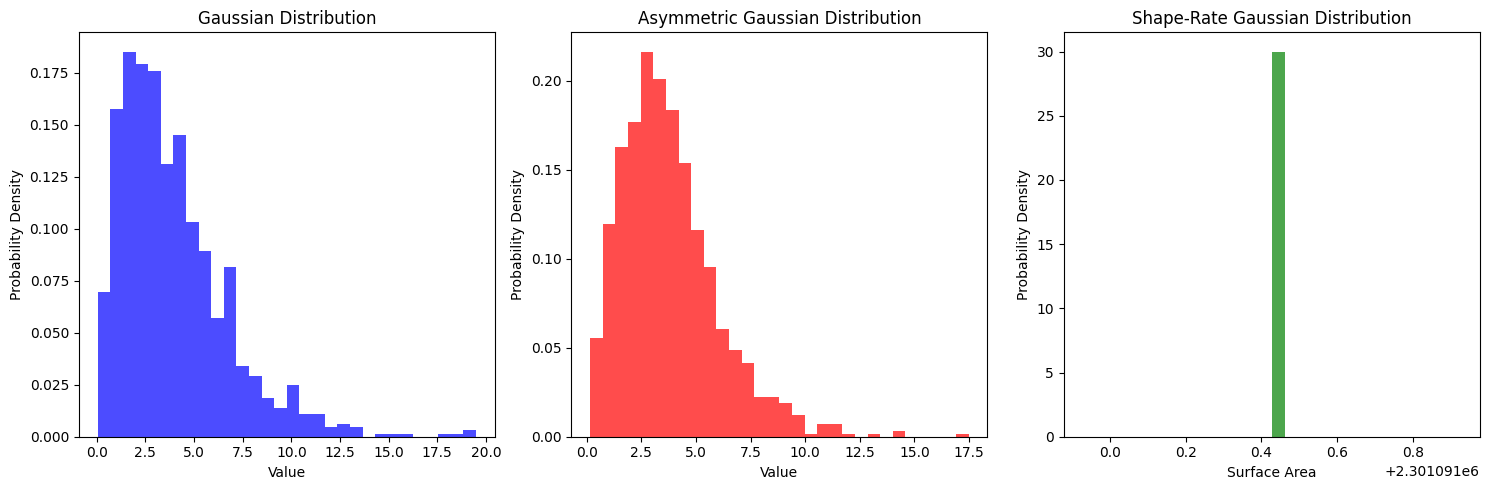

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, genpareto
import trimesh

# Load your own 3D object
mesh = trimesh.load('/content/simplestreet.obj')

# Generate random samples from a gamma distribution
shape = 2.0
scale = 2.0
size = 1000
gamma_samples = np.random.gamma(shape, scale, size)

# Generate random samples from an asymmetric gamma distribution
shape_left = 2.0
scale_left = 2.0
shape_right = 4.0
scale_right = 1.0
size = 1000
asymmetric_gamma_samples = np.concatenate((np.random.gamma(shape_left, scale_left, size//2),
                                           np.random.gamma(shape_right, scale_right, size//2)))

# Compute surface area from the 3D object
surface_area = mesh.area

# Fit Shape-Rate Gamma Distribution
params_gamma = gamma.fit(surface_area, floc=0, fscale=1)

# Plot histograms and 3D object
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(gamma_samples, bins=30, density=True, color='blue', alpha=0.7)
plt.title('Gaussian Distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')

plt.subplot(1, 3, 2)
plt.hist(asymmetric_gamma_samples, bins=30, density=True, color='red', alpha=0.7)
plt.title('Asymmetric Gaussian Distribution')
plt.xlabel('Value')
plt.ylabel('Probability Density')

plt.subplot(1, 3, 3)
plt.hist(surface_area, bins=30, density=True, color='green', alpha=0.7)
plt.plot(surface_area, gamma.pdf(surface_area, *params_gamma), color='purple', lw=2, label='Shape-Rate Gamma Fit')
plt.title('Shape-Rate Gaussian Distribution')
plt.xlabel('Surface Area')
plt.ylabel('Probability Density')

plt.tight_layout()
plt.show()


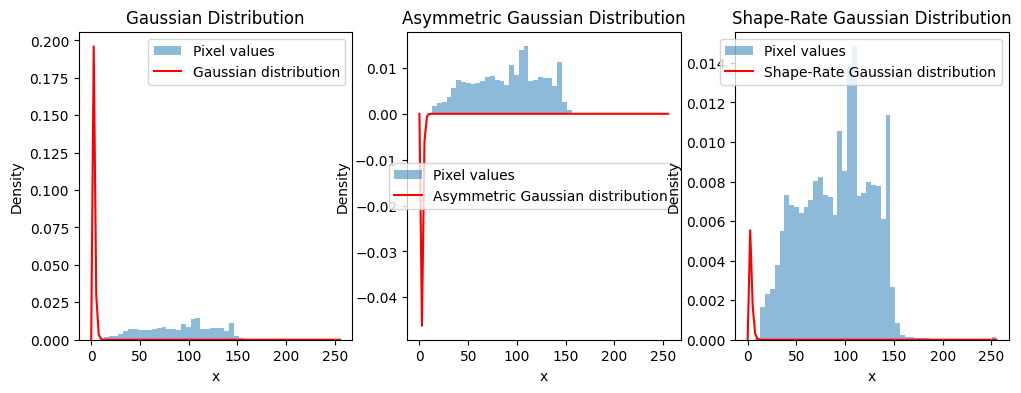

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm
from PIL import Image

# Function to extract pixel values from an image
def extract_pixels(img):
  img_array = np.array(img)
  pixels = img_array[:,:,0].flatten()  # Extract only the red channel
  return pixels

# Function to plot Gamma distribution
def plot_gamma(pixels, ax):
  x = np.linspace(0, max(pixels), 100)
  y = gamma.pdf(x, a=2, scale=1/1)
  ax.hist(pixels, bins=50, density=True, alpha=0.5, label='Pixel values')
  ax.plot(x, y, 'r-', label='Gaussian distribution')
  ax.set_xlabel('x')
  ax.set_ylabel('Density')
  ax.set_title('Gaussian Distribution')
  ax.legend()

# Function to plot Asymmetric Gamma distribution
def plot_asymmetric_gamma(pixels, ax):
  x = np.linspace(0, max(pixels), 100)
  y = gamma.pdf(x, a=2, scale=1/1) * (1 + 0.5 * (x - np.mean(pixels)) / np.std(pixels))
  ax.hist(pixels, bins=50, density=True, alpha=0.5, label='Pixel values')
  ax.plot(x, y, 'r-', label='Asymmetric Gaussian distribution')
  ax.set_xlabel('x')
  ax.set_ylabel('Density')
  ax.set_title('Asymmetric Gaussian Distribution')
  ax.legend()

# Function to plot Shape-Rate Gamma distribution
def plot_shape_rate_gamma(pixels, ax):
  x = np.linspace(0, max(pixels), 100)
  y = gamma.pdf(x, a=2, scale=1/1) * (x / np.mean(pixels))**(2 - 1)
  ax.hist(pixels, bins=50, density=True, alpha=0.5, label='Pixel values')
  ax.plot(x, y, 'r-', label='Shape-Rate Gaussian distribution')
  ax.set_xlabel('x')
  ax.set_ylabel('Density')
  ax.set_title('Shape-Rate Gaussian Distribution')
  ax.legend()

# Load the image
image = Image.open('/content/DRIVING_IN_THE_RAIN.jpg')

# Extract pixel values from the image
pixels = extract_pixels(image)

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Plot Gamma distribution
plot_gamma(pixels, axs[0])

# Plot Asymmetric Gamma distribution
plot_asymmetric_gamma(pixels, axs[1])

# Plot Shape-Rate Gamma distribution
plot_shape_rate_gamma(pixels, axs[2])

# Show the plot
plt.show()

In [ ]:
pip install pyntcloud


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.3/346.3 kB 6.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from skimage import color
from pyntcloud import PyntCloud
import os
import time

import numpy as np
import scipy
from scipy import stats
import pandas as pd
from scipy.stats import entropy
from scipy.special import gamma
from sklearn.preprocessing import scale, normalize

def my_scale(vec):
    vec = (vec - np.mean(vec)) / np.std(vec, ddof=1)
    return vec

def get_color_nss_param(vec):
    """Estimate color NSS parameters.
    :param vec: The vector that we want to approximate its parameter.
    :type vec: np.ndarray
    :scale is the normalization function
    """
    return [estimate_basic_param(vec)]

def get_geometry_nss_param(vec):
    """Estimate geometry NSS parameters.
    :param vec: The vector that we want to approximate its parameter.
    :type vec: np.ndarray
    :scale is the normalization function
    """
    return [estimate_basic_param(vec), estimate_ggd_param(vec), estimate_aggd_param(my_scale(vec)), estimate_gamma_param(vec)]

# def Entropy(labels):
#     probs = pd.Series(labels).value_counts(bins=2000) / len(labels)
#     en = stats.entropy(probs)
#     return en

def Entropy(labels):
    probs = pd.Series(labels).value_counts(normalize=True)
    en = stats.entropy(probs)
    return en


def estimate_basic_param(vec):
    """Estimate basic parameter.
    :param vec: The vector that we want to approximate its parameter.
    :type vec: np.ndarray
    """
    result = [np.mean(vec), np.std(vec, ddof=1), Entropy(vec)]
    return result

def estimate_ggd_param(vec):
    """Estimate GGD parameter.
    :param vec: The vector that we want to approximate its parameter.
    :type vec: np.ndarray
    """
    gam = np.arange(0.2, 10 + 0.001, 0.001)
    r_gam = (gamma(1.0 / gam) * gamma(3.0 / gam) / (gamma(2.0 / gam) ** 2))

    sigma_sq = np.mean(vec ** 2)
    sigma = np.sqrt(sigma_sq)
    E = np.mean(np.abs(vec))
    rho = sigma_sq / E ** 2

    differences = abs(rho - r_gam)
    array_position = np.argmin(differences)
    gamparam = gam[array_position]
    result = [gamparam, sigma]
    return result

def estimate_aggd_param(vec):
    """Estimate AGGD parameter.
    :param vec: The vector that we want to approximate its parameter.
    :type vec: np.ndarray
    """
    gam = np.arange(0.2, 10 + 0.001, 0.001)
    r_gam = ((gamma(2.0 / gam)) ** 2) / (
                gamma(1.0 / gam) * gamma(3.0 / gam))

    left_std = np.sqrt(np.mean((vec[vec < 0]) ** 2))
    right_std = np.sqrt(np.mean((vec[vec > 0]) ** 2))
    gamma_hat = left_std / right_std
    rhat = (np.mean(np.abs(vec))) ** 2 / np.mean((vec) ** 2)
    rhat_norm = (rhat * (gamma_hat ** 3 + 1) * (gamma_hat + 1)) / (
            (gamma_hat ** 2 + 1) ** 2)

    differences = (r_gam - rhat_norm) ** 2
    array_position = np.argmin(differences)
    alpha = gam[array_position]
    const = np.sqrt(gamma(1 / alpha)) / np.sqrt(gamma(3 / alpha))
    mean_param = (right_std - left_std) * (
                    gamma(2 / alpha) / gamma(1 / alpha)) * const
    result = [alpha, mean_param,left_std, right_std]
    return result

def estimate_gamma_param(vec):
    """Estimate Gamma parameter.
    :param vec: The vector that we want to approximate its parameter.
    :type vec: np.ndarray
    """
    mean = np.mean(vec)
    std = np.std(vec)
    shape = (mean/std)**2
    scale = (std**2)/mean
    result = [shape, scale]
    return result

# Example input vector
vec = np.array([1, 2, 3, 4, 5])

# Call the functions and store their outputs in variables
basic_param = estimate_basic_param(vec)
ggd_param = estimate_ggd_param(vec)
aggd_param = estimate_aggd_param(my_scale(vec))
gamma_param = estimate_gamma_param(vec)

# Print the variables containing the outputs
print("Basic Parameter:", basic_param)
print("GGD Parameter:", ggd_param)
print("AGGD Parameter:", aggd_param)
print("Gamma Parameter:", gamma_param)


def get_feature_vector(objpath):
  #load colored point cloud
  print("Begin loading point cloud")
  cloud = PyntCloud.from_file(objpath)

  #begin geometry projection
  print("Begin geometry feature extraction.")
  k_neighbors = cloud.get_neighbors(k=10)
  ev = cloud.add_scalar_field("eigen_values", k_neighbors=k_neighbors)
  cloud.add_scalar_field("curvature", ev=ev)
  cloud.add_scalar_field("anisotropy",ev=ev)
  cloud.add_scalar_field("linearity",ev=ev)
  cloud.add_scalar_field("planarity",ev=ev)
  cloud.add_scalar_field("sphericity",ev=ev)
  curvature = cloud.points['curvature(11)'].to_numpy()
  anisotropy = cloud.points['anisotropy(11)'].to_numpy()
  linearity = cloud.points['linearity(11)'].to_numpy()
  planarity = cloud.points['planarity(11)'].to_numpy()
  sphericity = cloud.points['sphericity(11)'].to_numpy()


  #begin color projection
  print("Begin color feature extraction.")
  rgb_color = cloud.points[['red','green','blue']].to_numpy()/255
  lab_color = color.rgb2lab(rgb_color)
  l = lab_color[:,0]
  a = lab_color[:,1]
  b = lab_color[:,2]


  print("Begin NSS parameters estimation.")
  # compute nss parameters
  nss_params = []
  # compute color nss features
  for tmp in [l,a,b]:
      params = get_color_nss_param(tmp)
      #flatten the feature vector
      nss_params = nss_params + [i for item in params for i in item]
  # compute geomerty nss features
  for tmp in [curvature,anisotropy,linearity,planarity,sphericity]:
      params = get_geometry_nss_param(tmp)
      #flatten the feature vector
      nss_params = nss_params + [i for item in params for i in item]
  return nss_params

#demo
objpath = "/content/hhi_5.ply"
features = get_feature_vector(objpath)

#show the features
cnt = 0
for feature_domain in ['l','a','b']:
    for param in ["mean","std","entropy"]:
        print(feature_domain + "_" + param + ": " + str(features[cnt]))
        cnt = cnt + 1
for feature_domain in ['curvature','anisotropy','linearity','planarity','sphericity']:
    for param in ["mean","std","entropy","ggd1","ggd2","aggd1","aggd2","aggd3","aggd4","gamma1","gamma2"]:
        print(feature_domain + "_" + param + ": " + str(features[cnt]))
        cnt = cnt + 1


objpath = "/content/hhi_5.ply"
start = time.time()
features = get_feature_vector(objpath)
end = time.time()
time_cost = end-start

print(f"Number of features returned: {len(features)}")


#show the features
color_features = ['l', 'a', 'b']
geometry_features = ['curvature', 'anisotropy', 'linearity', 'planarity', 'sphericity']

cnt = 0
# Color features
for feature_domain in color_features:
  for param in ["mean", "std", "entropy"]:
    print(feature_domain + "_" + param + ": " + str(features[cnt]))
    cnt += 1

# Geometry features
for feature_domain in geometry_features:
  for param in ["mean", "std", "entropy", "ggd1", "ggd2", "aggd1", "aggd2", "aggd3", "aggd4", "gamma1", "gamma2"]:
    print(feature_domain + "_" + param + ": " + str(features[cnt]))
    cnt += 1

Basic Parameter: [3.0, 1.5811388300841898, 1.6094379124341005]
GGD Parameter: [10.000000000000007, 3.3166247903554]
AGGD Parameter: [5.033000000000005, 0.0, 1.0, 1.0]
Gamma Parameter: [4.499999999999999, 0.6666666666666669]
Begin loading point cloud
Begin geometry feature extraction.
Begin color feature extraction.
Begin NSS parameters estimation.
l_mean: 30.953925982361476
l_std: 17.582873385011077
l_entropy: 5.57597785234483
a_mean: 0.46019870199980717
a_std: 4.855343454052478
a_entropy: 5.57597785234483
b_mean: -4.016669681596996
b_std: 6.10997046478548
b_entropy: 5.57597785234483
curvature_mean: 0.08899558
curvature_std: 0.033052377
curvature_entropy: 5.746280378291367
curvature_ggd1: 10.000000000000007
curvature_ggd2: 0.094935045
curvature_aggd1: 1.1110000000000009
curvature_aggd2: 0.12737958844458236
curvature_aggd3: 0.9146807
curvature_aggd4: 1.090398
curvature_gamma1: 7.249970282839286
curvature_gamma2: 0.01227530390124734
anisotropy_mean: 0.8277261
anisotropy_std: 0.07023936
a

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
def create_cnn_model(input_shape, num_filters=64, kernel_size=3, dense_units=128):
    model = models.Sequential()
    model.add(layers.Conv1D(num_filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dense(1))  # Output layer for regression task
    model.compile(optimizer='adam', loss='mean_squared_error')  # Adjust loss based on your task
    return model

def get_data(train_name_list, test_name_list):
    feature_data = pd.read_csv("/content/features_sjtu.csv", index_col=0, keep_default_na=False)
    feature_data = feature_data[feature_data.columns.values]
    score_data = pd.read_csv("/content/mos_sjtu.csv")
    train_set = []
    train_score = []
    test_set = []
    test_score = []

    for name in train_name_list:
        score = score_data[name].tolist()
        train_score = train_score + score
        for i in range(42):
            name_pc = name + str(i)
            data = feature_data.loc[name_pc, :].tolist()
            train_set.append(data)

    for name in test_name_list:
        score = score_data[name].tolist()
        test_score = test_score + score
        for i in range(42):
            name_pc = name + str(i)
            data = feature_data.loc[name_pc, :].tolist()
            test_set.append(data)

    # Print some information about the data
    print("Number of samples in train_set before scaling:", len(train_set))
    print("Length of a single feature vector before scaling:", len(train_set[0]))

    # Reshape data for CNN (assuming 1D convolution)
    train_set = np.array(train_set).reshape(len(train_set), -1, 1)
    test_set = np.array(test_set).reshape(len(test_set), -1, 1)

    # preprocessing
    scaler = MinMaxScaler()
    train_set = scaler.fit_transform(train_set.reshape(len(train_set), -1)).reshape(len(train_set), -1, 1)
    test_set = scaler.transform(test_set.reshape(len(test_set), -1)).reshape(len(test_set), -1, 1)

    return train_set, np.array(train_score) / 10, test_set, np.array(test_score) / 10


if __name__ == '__main__':
    plcc = []
    srcc = []
    krcc = []
    cnt = 0


    num_filters_list = [32, 64, 128]
    kernel_size_list = [3, 5, 7]
    dense_units_list = [64, 128, 256]

    for num_filters in num_filters_list:
        for kernel_size in kernel_size_list:
            for dense_units in dense_units_list:
                cnt = cnt + 1
                print(f"\n\nExperiment {cnt}: num_filters={num_filters}, kernel_size={kernel_size}, dense_units={dense_units}")
                plcc_temp = []
                srcc_temp = []
                krcc_temp = []

                for i in range(9):
                    # generate train_name_list and test_name_list
                    train_name_list = ['redandblack', 'Romanoillamp', 'loot', 'soldier', 'ULB Unicorn', 'longdress', 'statue', 'shiva',
                                       'hhi']
                    test_name_list = [train_name_list.pop(i)]

                    # get data
                    print(f'Begin split {i + 1} and use the following list as test set:')
                    print(test_name_list)
                    train_set, train_score, test_set, test_score = get_data(train_name_list, test_name_list)

                    # CNN model training
                    cnn_model = create_cnn_model(input_shape=(len(train_set[0]), 1), num_filters=num_filters, kernel_size=kernel_size, dense_units=dense_units)
                    cnn_model.fit(train_set, train_score, epochs=10, batch_size=32, verbose=1)

                    # Predict scores using CNN
                    predict_score = cnn_model.predict(test_set).flatten()

                    # record the result
                    plcc_temp.append(stats.pearsonr(predict_score, test_score)[0])
                    srcc_temp.append(stats.spearmanr(predict_score, test_score)[0])
                    krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])

                    print('Training complete!')
                    print('------------------------------------------------------------------------------------------------------------------')

                # Average results over 9 folds
                avg_plcc = sum(plcc_temp) / len(plcc_temp)
                avg_srcc = sum(srcc_temp) / len(srcc_temp)
                avg_krcc = sum(krcc_temp) / len(krcc_temp)

                # record the result for this parameter setting
                plcc.append(avg_plcc)
                srcc.append(avg_srcc)
                krcc.append(avg_krcc)

                print(f'\nAverage results for this parameter setting (num_filters={num_filters}, kernel_size={kernel_size}, dense_units={dense_units}):')
                print("PLCC:  " + str(avg_plcc))
                print("SRCC:  " + str(avg_srcc))
                print("KRCC:  " + str(avg_krcc))

    print('------------------------------------------------------------------------------------------------------------------')
    print('Final Results presentation:')
    print("PLCC:  " + str(plcc))
    print("SRCC:  " + str(srcc))
    print("KRCC:  " + str(krcc))




Experiment 1: num_filters=32, kernel_size=3, dense_units=64
Begin split 1 and use the following list as test set:
['redandblack']
Number of samples in train_set before scaling: 336
Length of a single feature vector before scaling: 64
Epoch 1/10
11/11 [==============================] - 1s 4ms/step - loss: 0.1143
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0509
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0416
Epoch 4/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0359
Epoch 5/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0319
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0296
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0264
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 9/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0225
Epoch 10/10
2/2 [==============================] - 0s

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 3ms/step - loss: 0.1386
Epoch 2/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0608
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0468
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0428
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0380
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0334
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0299
Epoch 8/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0278
Epoch 9/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0253
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in train_se

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 6ms/step - loss: 0.2224
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0698
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0463
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0388
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0362
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0339
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0313
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0302
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0285
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples in train

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 5ms/step - loss: 0.0983
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0477
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0421
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0353
Epoch 5/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0329
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0289
Epoch 7/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0281
Epoch 8/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0256
Epoch 9/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0254
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of samples in t

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 4ms/step - loss: 0.1641
Epoch 2/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0695
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0483
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0390
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0353
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0305
Epoch 7/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0296
Epoch 8/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0257
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0238
Epoch 10/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0218


2/2 [==============================] - 0s 6ms/step


<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of samples in train_set before scaling: 336
Length of a single feature vector before scaling: 64
Epoch 1/10
11/11 [==============================] - 1s 4ms/step - loss: 0.1130
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0534
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0395
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0347
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0311
Epoch 6/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0301
Epoch 7/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0286
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0241
Epoch 9/10
11/11 [==============================] - 0s 4ms/ste

2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']


<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Number of samples in train_set before scaling: 336
Length of a single feature vector before scaling: 64
Epoch 1/10
11/11 [==============================] - 1s 4ms/step - loss: 0.1288
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0535
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0407
Epoch 4/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0330
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0293
Epoch 6/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0264
Epoch 7/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0248
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0249
Epoch 9/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0237
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
-------------------------------------------------------------------------------------------------------

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 4ms/step - loss: 0.1619
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0561
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0448
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0392
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0361
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0336
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0316
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0295
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0282
Epoch 10/10
2/2 [==============================] - 0s 4ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in train_set before sca

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 4ms/step - loss: 0.1125
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0500
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0376
Epoch 4/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0325
Epoch 5/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0293
Epoch 6/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0270
Epoch 7/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0245
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0238
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0218
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=32, kernel_size=3, dense_units=64):
PLCC:  0.7

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 8ms/step - loss: 0.1010
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0484
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0402
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0398
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0361
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0288
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0259
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0248
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0234
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of samples in train_set b

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 11ms/step - loss: 0.0932
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0459
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0377
Epoch 4/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0312
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0268
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0257
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0212
Epoch 8/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0203
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0187
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in train_s

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 5ms/step - loss: 0.1172
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0499
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0399
Epoch 4/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0320
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0287
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0252
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0239
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0208
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0195
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples in train

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 4ms/step - loss: 0.1124
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0454
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0372
Epoch 4/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0344
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0291
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0262
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0235
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0225
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0215
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of samples in t

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 4ms/step - loss: 0.1515
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0506
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0416
Epoch 4/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0353
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0315
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0302
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0283
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0241
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0227
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of samples in tra

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 5ms/step - loss: 0.1084
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0466
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0371
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0312
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0272
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0244
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0214
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0212
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0179
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples in train_

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.1506
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0529
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0395
Epoch 4/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0342
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0297
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0280
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0249
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0211
Epoch 9/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0190
Epoch 10/10
2/2 [==============================] - 0s 12ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples in trai

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 8ms/step - loss: 0.1232
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0498
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0348
Epoch 4/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0321
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0299
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0286
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0233
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0207
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0182
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in train_set

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 4ms/step - loss: 0.0929
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0443
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0386
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0312
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0275
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0240
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0222
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0205
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0201
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=32, kernel_size=3, dense_units=128)

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.1693
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0554
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0444
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0414
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0340
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0298
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0275
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0250
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0228
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of samples in 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 6ms/step - loss: 0.2114
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0567
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0445
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0362
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0330
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0286
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0265
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0243
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0228
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in train_se

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 8ms/step - loss: 0.1931
Epoch 2/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0554
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0444
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0398
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0355
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0302
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0276
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0250
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0230
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples in train_set 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 3s 15ms/step - loss: 0.1572
Epoch 2/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0616
Epoch 3/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0399
Epoch 4/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0337
Epoch 5/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0312
Epoch 6/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0280
Epoch 7/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0248
Epoch 8/10
11/11 [==============================] - 0s 19ms/step - loss: 0.0233
Epoch 9/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0215
Epoch 10/10
2/2 [==============================] - 0s 13ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']


<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Number of samples in train_set before scaling: 336
Length of a single feature vector before scaling: 64
Epoch 1/10
11/11 [==============================] - 2s 10ms/step - loss: 0.1512
Epoch 2/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0573
Epoch 3/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0367
Epoch 4/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0310
Epoch 5/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0280
Epoch 6/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0255
Epoch 7/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0231
Epoch 8/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0201
Epoch 9/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0186
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
----------------------------------------------------------------------------------------------

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.1380
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0493
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0395
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0339
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0321
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0277
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0257
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0193
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples in train_

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 6ms/step - loss: 0.1446
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0471
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0385
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0341
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0292
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0268
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0234
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0195
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0200
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples in train_s

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 6ms/step - loss: 0.1689
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0663
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0433
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0355
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0297
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0269
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0257
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0254
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0218
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in train_s

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 13ms/step - loss: 0.2050
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0604
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0434
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0337
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0296
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0264
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0236
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0214
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0196
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=32, kernel_size=3, dense_unit

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 4ms/step - loss: 0.1368
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0658
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0467
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0408
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0372
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0332
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0314
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0288
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0269
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of samples in 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 4ms/step - loss: 0.1076
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0648
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0466
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0343
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0308
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0266
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0238
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0225
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0196
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in train_se

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 4ms/step - loss: 0.0911
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0468
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0346
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0293
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0233
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0223
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0233
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0204
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0174
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples in train

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 4ms/step - loss: 0.0964
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0421
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0390
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0287
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0244
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0217
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0199
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0204
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0174
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of samples in t

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 4ms/step - loss: 0.1929
Epoch 2/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0714
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0494
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0412
Epoch 5/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0351
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0313
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0290
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0259
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0238
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of samples in tra

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 4ms/step - loss: 0.1096
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0553
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0422
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0374
Epoch 5/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0337
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0314
Epoch 7/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0288
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0268
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0244
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples in train_set before 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 6ms/step - loss: 0.1198
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0617
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0451
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0366
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0301
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0279
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0253
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0243
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0195
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples in train_s

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 4ms/step - loss: 0.1293
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0617
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0469
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0412
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0345
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0315
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0302
Epoch 8/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0274
Epoch 9/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0242
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in train_set before sca

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 4ms/step - loss: 0.1151
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0566
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0405
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0352
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0303
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0285
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0259
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0235
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0219
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=32, kernel_size=5, dense_units=64):

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 5ms/step - loss: 0.1226
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0518
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0400
Epoch 4/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0381
Epoch 5/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0381
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0303
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0267
Epoch 8/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0243
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0223
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of samples in 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 5ms/step - loss: 0.1210
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0513
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0401
Epoch 4/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0336
Epoch 5/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0286
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0255
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0238
Epoch 8/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0213
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0208
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in train_set before sc

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 5ms/step - loss: 0.1782
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0628
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0453
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0385
Epoch 5/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0338
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0312
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0286
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0260
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0244
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples in train

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 5ms/step - loss: 0.1308
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0474
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0439
Epoch 4/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0331
Epoch 5/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0279
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0277
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0245
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0259
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0227
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of samples in train_set be

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.0560
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0351
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0274
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0213
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0183
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0174
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0158
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0157
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0149
Epoch 10/10
2/2 [==============================] - 0s 9ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of samples in tra

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 5ms/step - loss: 0.1224
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0511
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0391
Epoch 4/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0338
Epoch 5/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0302
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0274
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0245
Epoch 8/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0240
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0200
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples in train_

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 5ms/step - loss: 0.0965
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0433
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0384
Epoch 4/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0310
Epoch 5/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0255
Epoch 6/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0241
Epoch 7/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0213
Epoch 8/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0195
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0191
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples in train_set bef

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 5ms/step - loss: 0.0935
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0438
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0347
Epoch 4/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0288
Epoch 5/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0254
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0257
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0246
Epoch 8/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0196
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0188
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in train_set before sca

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 5ms/step - loss: 0.1240
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0530
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0370
Epoch 4/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0307
Epoch 5/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0268
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0249
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0225
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0208
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0178
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=32, kernel_size=5, dense_units=128)

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.1113
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0501
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0370
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0313
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0280
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0250
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0245
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0208
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0183
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of samples in 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.1332
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0569
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0429
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0382
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0301
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0258
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0217
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0198
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0186
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 11ms/step - loss: 0.1447
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0579
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0405
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0340
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0284
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0257
Epoch 7/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0218
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0194
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0179
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 7ms/step - loss: 0.1253
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0462
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0347
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0301
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0282
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0266
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0221
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0205
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0192
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of samples in train_set be

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 6ms/step - loss: 0.1278
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0435
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0323
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0271
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0234
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0193
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0176
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0166
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0150
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of samples in tra

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 6ms/step - loss: 0.1833
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0568
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0417
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0399
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0373
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0320
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0304
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0256
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0250
Epoch 10/10
2/2 [==============================] - 0s 9ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples in train_set before 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 6ms/step - loss: 0.1111
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0549
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0428
Epoch 4/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0344
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0293
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0253
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0231
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0211
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0195
Epoch 10/10
2/2 [==============================] - 0s 9ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples in train_s

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.1315
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0411
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0358
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0290
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0273
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0253
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0224
Epoch 8/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0205
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0185
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in trai

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.0956
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0437
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0323
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0264
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0219
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0189
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0177
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0174
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0145
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=32, kernel_size=5, dense_un

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 4ms/step - loss: 0.1274
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0581
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0430
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0379
Epoch 5/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0343
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0324
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0293
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0278
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0267
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of samples in 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 4ms/step - loss: 0.2081
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0552
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0466
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0407
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0362
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0322
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0291
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0273
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0261
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in train_se

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 5ms/step - loss: 0.1254
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0597
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0444
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0359
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0318
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0281
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0265
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0231
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0216
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples in train

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 4ms/step - loss: 0.1027
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0511
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0398
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0352
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0293
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0259
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0233
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0214
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0191
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of samples in train_set be

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 4ms/step - loss: 0.1153
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0600
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0432
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0371
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0321
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0284
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0255
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0231
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0219
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of samples in tra

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 4ms/step - loss: 0.0609
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0362
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0296
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0243
Epoch 5/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0220
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0191
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0169
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0154
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0150
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples in train_

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.1020
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0455
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0377
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0323
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0321
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0291
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0269
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0238
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0210
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples in train_s

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 4ms/step - loss: 0.1010
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0525
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0399
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0329
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0290
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0248
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0224
Epoch 8/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0235
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0189
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in train_set

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 4ms/step - loss: 0.1417
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0576
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0441
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0360
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0317
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0294
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0272
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0253
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0240
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=32, kernel_size=7, dense_units=64):

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 5ms/step - loss: 0.0753
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0425
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0329
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0274
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0295
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0215
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0197
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0209
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0176
Epoch 10/10
2/2 [==============================] - 0s 10ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']


<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Number of samples in train_set before scaling: 336
Length of a single feature vector before scaling: 64
Epoch 1/10
11/11 [==============================] - 1s 5ms/step - loss: 0.1305
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0537
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0376
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0332
Epoch 5/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0289
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0257
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0236
Epoch 8/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0210
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0189
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
-------------------------------------------------------------------------------------------------------

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 5ms/step - loss: 0.0794
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0391
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0334
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0271
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0226
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0221
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0203
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0177
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0159
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples in train

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.0941
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0484
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0370
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0325
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0284
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0249
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0240
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0220
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0180
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of samples in 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 6ms/step - loss: 0.1290
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0546
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0365
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0282
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0253
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0217
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0196
Epoch 8/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0175
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0169
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of samples in tra

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 6ms/step - loss: 0.1743
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0642
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0453
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0397
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0362
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0334
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0302
Epoch 8/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0280
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0263
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples in train_

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 5ms/step - loss: 0.1594
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0670
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0462
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0391
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0353
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0324
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0290
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0269
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0247
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples in train_s

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 5ms/step - loss: 0.0880
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0393
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0328
Epoch 4/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0283
Epoch 5/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0250
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0225
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0204
Epoch 8/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0182
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0174
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in train_set before sca

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.0777
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0370
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0366
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0297
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0242
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0203
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0191
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0186
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0152
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=32, kernel_size=7, dense_units=128

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1360
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0484
Epoch 3/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0391
Epoch 4/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0324
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0285
Epoch 6/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0262
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0248
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0210
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0193
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of sampl

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.2266
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0714
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0506
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0363
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0315
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0293
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0268
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0241
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0223
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in train_se

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 6ms/step - loss: 0.1350
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0496
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0403
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0321
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0273
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0256
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0252
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0230
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0202
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples in train_set before

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 6ms/step - loss: 0.1379
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0655
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0407
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0317
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0286
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0248
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0230
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0200
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of samples in t

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.1452
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0574
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0390
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0291
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0240
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0182
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0167
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0156
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of samples in tra

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1448
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0527
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0442
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0429
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0337
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0307
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0274
Epoch 8/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0237
Epoch 9/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0208
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.0899
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0402
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0318
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0264
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0226
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0205
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0178
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0168
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0146
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples in train_

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.0842
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0344
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0315
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0250
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0200
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0179
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0157
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0156
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0137
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in train_set

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 7ms/step - loss: 0.1574
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0510
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0366
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0305
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0261
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0224
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0200
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0177
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0159
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=32, kernel_size=7, dense_units=256):
PLCC:  0.

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 5ms/step - loss: 0.0696
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0457
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0348
Epoch 4/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0297
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0263
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0254
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0221
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0194
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0185
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of samples in 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 5ms/step - loss: 0.1090
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0499
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0384
Epoch 4/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0343
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0265
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0240
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0217
Epoch 8/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0204
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0179
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in train_set before sc

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 6ms/step - loss: 0.0984
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0373
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0326
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0267
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0264
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0223
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0212
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0187
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples in train

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.1114
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0459
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0377
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0335
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0298
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0293
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0251
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0232
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0226
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of samples in t

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 6ms/step - loss: 0.1093
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0488
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0404
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0312
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0265
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0225
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0202
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0179
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0166
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of samples in tra

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 8ms/step - loss: 0.1124
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0522
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0418
Epoch 4/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0355
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0321
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0289
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0258
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0260
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0227
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples in train_

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 5ms/step - loss: 0.1369
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0634
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0456
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0395
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0334
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0306
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0274
Epoch 8/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0248
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0212
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples in train_s

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 6ms/step - loss: 0.1054
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0511
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0400
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0351
Epoch 5/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0318
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0283
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0256
Epoch 8/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0224
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0205
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in train_set

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 6ms/step - loss: 0.1237
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0514
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0402
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0353
Epoch 5/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0299
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0268
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0234
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0212
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0191
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=64, kernel_size=3, dense_units=64):

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 11ms/step - loss: 0.1232
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0543
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0435
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0355
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0312
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0294
Epoch 7/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0258
Epoch 8/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0243
Epoch 9/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0226
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of sa

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 13ms/step - loss: 0.1399
Epoch 2/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0516
Epoch 3/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0393
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0346
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0302
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0304
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0287
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0224
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0206
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in trai

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 2s 8ms/step - loss: 0.1083
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0433
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0365
Epoch 4/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0292
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0252
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0219
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0215
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0193
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0172
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples in train

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.1240
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0419
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0374
Epoch 4/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0345
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0283
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0245
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0222
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0212
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0211
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of samples in t

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.1179
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0510
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0394
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0337
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0284
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0248
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0214
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0199
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0177
Epoch 10/10
2/2 [==============================] - 0s 12ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of samples in tr

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 12ms/step - loss: 0.1146
Epoch 2/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0508
Epoch 3/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0392
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0324
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0290
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0265
Epoch 7/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0245
Epoch 8/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0204
Epoch 9/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0170
Epoch 10/10
2/2 [==============================] - 0s 9ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.1113
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0500
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0426
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0360
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0309
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0264
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0241
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0222
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0247
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples in train_s

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 8ms/step - loss: 0.1057
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0458
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0376
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0323
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0285
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0279
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0250
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0232
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0211
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in train_set before sca

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.1177
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0466
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0370
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0322
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0278
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0270
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0232
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0227
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0200
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=64, kernel_size=3, dense_units=128)

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 11ms/step - loss: 0.1378
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0490
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0377
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0323
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0260
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0233
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0205
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0201
Epoch 9/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0165
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of sampl

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1544
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0578
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0409
Epoch 4/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0351
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0289
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0239
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0207
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0204
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0184
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in tr

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.1007
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0434
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0380
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0314
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0261
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0229
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0204
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0198
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0180
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples in t

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 10ms/step - loss: 0.1003
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0453
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0334
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0293
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0251
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0229
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0207
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0196
Epoch 9/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0164
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of samples in train_se

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 9ms/step - loss: 0.1198
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0433
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0343
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0275
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0241
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0217
Epoch 7/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0209
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0173
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0181
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of samples in train_set

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1747
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0645
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0408
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0349
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0313
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0305
Epoch 7/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0261
Epoch 8/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0278
Epoch 9/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0250
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples in

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1512
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0548
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0415
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0350
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0319
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0277
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0260
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0233
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0212
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples in 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1210
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0519
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0368
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0310
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0261
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0237
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0228
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0207
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0190
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in trai

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1400
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0568
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0385
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0337
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0279
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0242
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0252
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0202
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0187
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=64, kernel_size=3, dense_units

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 5ms/step - loss: 0.1340
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0511
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0418
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0354
Epoch 5/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0321
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0295
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 8/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0236
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0221
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of samples in 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 5ms/step - loss: 0.0999
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0467
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0406
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0342
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0292
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0267
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0233
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0218
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0196
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in train_s

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.1542
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0608
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0456
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0394
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0338
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0301
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0264
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0249
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0221
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples in trai

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 5ms/step - loss: 0.1326
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0643
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0465
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0400
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0359
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0333
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0298
Epoch 8/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0283
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0260
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of samples in t

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 6ms/step - loss: 0.0973
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0464
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0371
Epoch 4/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0313
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0282
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0231
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0200
Epoch 8/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0195
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0172
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of samples in train_set befo

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 5ms/step - loss: 0.1217
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0509
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0383
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0381
Epoch 5/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0308
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0294
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0251
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0228
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0238
Epoch 10/10
2/2 [==============================] - 0s 9ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples in train_

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 5ms/step - loss: 0.1055
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0514
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0403
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0344
Epoch 5/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0276
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0263
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0277
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0234
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0186
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples in train_s

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 9ms/step - loss: 0.1039
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0482
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0379
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0317
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0288
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0252
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0227
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0208
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0194
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in train_set before sc

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 11ms/step - loss: 0.1345
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0586
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0430
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0349
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0307
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0269
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0245
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0223
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0207
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=64, kernel_size=5, dense_units=64)

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 7ms/step - loss: 0.1505
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0558
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0413
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0366
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0325
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0289
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0261
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0242
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0218
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of samples in train_set b

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 7ms/step - loss: 0.1506
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0567
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0452
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0345
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0302
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0265
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0247
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0214
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0198
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in train_set before sc

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.1259
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0520
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0445
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0352
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0319
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0273
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0245
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0231
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0201
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples in train

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.1047
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0474
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0488
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0341
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0297
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0259
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0246
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0218
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0191
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of samples in t

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.0992
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0428
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0309
Epoch 4/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0245
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0204
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0177
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0163
Epoch 8/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0153
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0136
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of samples

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.1524
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0517
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0416
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0360
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0319
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0302
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0259
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0235
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0217
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples in train_

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 2s 7ms/step - loss: 0.1424
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0540
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0411
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0366
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0326
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0269
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0238
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0220
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0197
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples in train_set before s

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.1061
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0459
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0350
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0299
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0249
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0221
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0199
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0185
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0178
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in train_set

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 8ms/step - loss: 0.0963
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0439
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0356
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0297
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0257
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0225
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0200
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0186
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0160
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=64, kernel_size=5, dense_units=128)

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 13ms/step - loss: 0.1225
Epoch 2/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0523
Epoch 3/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0396
Epoch 4/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0339
Epoch 5/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0305
Epoch 6/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0279
Epoch 7/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0251
Epoch 8/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0238
Epoch 9/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0208
Epoch 10/10
2/2 [==============================] - 0s 10ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of s

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.1556
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0720
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0421
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0372
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0319
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0288
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0264
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0245
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0224
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in tr

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1197
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0463
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0389
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0298
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0263
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0227
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0218
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0183
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0173
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1503
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0536
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0397
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0338
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0291
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0263
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0235
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0233
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0206
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of samples

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 14ms/step - loss: 0.1588
Epoch 2/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0537
Epoch 3/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0358
Epoch 4/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0287
Epoch 5/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0236
Epoch 6/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0196
Epoch 7/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0180
Epoch 8/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0162
Epoch 9/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0158
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of sampl

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 14ms/step - loss: 0.1320
Epoch 2/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0457
Epoch 3/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0386
Epoch 4/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0302
Epoch 5/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0261
Epoch 6/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0230
Epoch 7/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0222
Epoch 8/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0183
Epoch 9/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0169
Epoch 10/10
2/2 [==============================] - 0s 10ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1338
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0514
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0362
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0301
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0271
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0233
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0208
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0186
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0167
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples i

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 11ms/step - loss: 0.1765
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0676
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0392
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0345
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0334
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0308
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0271
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0245
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0228
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in tra

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1253
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0426
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0342
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0278
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0243
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0218
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0193
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0181
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0167
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=64, kernel_size=5, dense_uni

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 6ms/step - loss: 0.1109
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0570
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0439
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0360
Epoch 5/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0328
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0300
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0259
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0241
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0211
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of samples in 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.0978
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0473
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0370
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0288
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0290
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0245
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0214
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0187
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0187
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in train_se

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 6ms/step - loss: 0.0950
Epoch 2/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0452
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0402
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0316
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0288
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0253
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0234
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0198
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0192
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples in train

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 5ms/step - loss: 0.1126
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0514
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0428
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0355
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0295
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0263
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0253
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0217
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0193
Epoch 10/10
2/2 [==============================] - 0s 9ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of samples in t

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 6ms/step - loss: 0.1071
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0468
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0345
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0281
Epoch 5/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0244
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0205
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0190
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0173
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0164
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of samples in train_set befo

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 6ms/step - loss: 0.1120
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0478
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0413
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0343
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0315
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0278
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0266
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0253
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0218
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples in train_

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 5ms/step - loss: 0.1259
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0543
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0483
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0374
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0332
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0328
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0286
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0253
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0225
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples in train_set before s

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1402
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0548
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0391
Epoch 4/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0330
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0307
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0261
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0230
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0208
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0201
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in trai

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 6ms/step - loss: 0.1203
Epoch 2/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0529
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0409
Epoch 4/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0328
Epoch 5/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0282
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0265
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0224
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0202
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0195
Epoch 10/10
2/2 [==============================] - 0s 4ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=64, kernel_size=7, dense_units=64):
PLCC:  0.7

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.1224
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0468
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0383
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0336
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0281
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0260
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0235
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0214
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0204
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of samples in 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 8ms/step - loss: 0.1077
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0494
Epoch 3/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0397
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0319
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0279
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0254
Epoch 7/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0220
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0186
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0187
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in train_se

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.1157
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0453
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0360
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0317
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0276
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0238
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0230
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0189
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0191
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples in train

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 8ms/step - loss: 0.1593
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0546
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0394
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0340
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0295
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0258
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0227
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0208
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0207
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of samples in train_set be

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1114
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0431
Epoch 3/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0316
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0264
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0222
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0197
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0193
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0171
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0152
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of sampl

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 8ms/step - loss: 0.1285
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0470
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0405
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0321
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0287
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0246
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0219
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0209
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0179
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples in train_

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.1133
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0550
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0387
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0360
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0339
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0290
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0264
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0272
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0204
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples in train_s

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.0920
Epoch 2/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0476
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0341
Epoch 4/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0290
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0251
Epoch 6/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0213
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0186
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0165
Epoch 9/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0153
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in train_set

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 7ms/step - loss: 0.1149
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0498
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0362
Epoch 4/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0305
Epoch 5/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0280
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0240
Epoch 7/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0208
Epoch 8/10
11/11 [==============================] - 0s 7ms/step - loss: 0.0199
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0169
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=64, kernel_size=7, dense_units=128)

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.1061
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0466
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0340
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0314
Epoch 5/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0255
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0239
Epoch 7/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0214
Epoch 8/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0185
Epoch 9/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0168
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of sampl

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 14ms/step - loss: 0.1162
Epoch 2/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0597
Epoch 3/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0353
Epoch 4/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0298
Epoch 5/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0235
Epoch 6/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0219
Epoch 7/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0190
Epoch 8/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0201
Epoch 9/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0172
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 10ms/step - loss: 0.1165
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0444
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0340
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0297
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0267
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0231
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0211
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0214
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0203
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples in train_set 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.1610
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0563
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0412
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0334
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0299
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0274
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0251
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0238
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0202
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of samples

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.1397
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0464
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0350
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0284
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0233
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0199
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0193
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0167
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0159
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of samples i

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 9ms/step - loss: 0.2215
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0556
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0428
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0367
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0345
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0300
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0250
Epoch 8/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0233
Epoch 9/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0228
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples in train_set b

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 3s 10ms/step - loss: 0.1559
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0575
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0429
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0353
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0290
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0263
Epoch 7/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0223
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0205
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0182
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples in

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.1146
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0474
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0349
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0373
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0302
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0249
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0222
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0217
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0177
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in train

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.0938
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0394
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0298
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0237
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0189
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0169
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0154
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0133
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0159
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=64, kernel_size=7, dense_un

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 8ms/step - loss: 0.0819
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0424
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0350
Epoch 4/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0301
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0275
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0263
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0206
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0198
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0193
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of samples in 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 8ms/step - loss: 0.1067
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0493
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0334
Epoch 4/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0290
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0237
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0229
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0206
Epoch 8/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0227
Epoch 9/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0230
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in train

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 14ms/step - loss: 0.1163
Epoch 2/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0513
Epoch 3/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0402
Epoch 4/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0329
Epoch 5/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0276
Epoch 6/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0239
Epoch 7/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0227
Epoch 8/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0215
Epoch 9/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0207
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.1022
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0450
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0373
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0312
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0271
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0242
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0215
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0238
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0176
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of samples in t

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 8ms/step - loss: 0.1150
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0528
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0420
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0303
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0279
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0237
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0223
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0194
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0178
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of samples in tra

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 8ms/step - loss: 0.1184
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0577
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0396
Epoch 4/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0324
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0280
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0251
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0226
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0202
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0174
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples in train_

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.1097
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0545
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0396
Epoch 4/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0344
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0303
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0279
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0262
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0250
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0211
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples in train_

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 14ms/step - loss: 0.0928
Epoch 2/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0480
Epoch 3/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0397
Epoch 4/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0313
Epoch 5/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0267
Epoch 6/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0270
Epoch 7/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0210
Epoch 8/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0201
Epoch 9/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0195
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 8ms/step - loss: 0.0883
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0433
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0345
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0288
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0245
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0224
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0203
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0190
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0199
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=128, kernel_size=3, dense_units=64

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1492
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0572
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0409
Epoch 4/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0344
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0301
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0270
Epoch 7/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0255
Epoch 8/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0250
Epoch 9/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0210
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of sa

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 12ms/step - loss: 0.1183
Epoch 2/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0450
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0361
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0292
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0266
Epoch 6/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0233
Epoch 7/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0219
Epoch 8/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0201
Epoch 9/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0178
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 11ms/step - loss: 0.0936
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0442
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0329
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0320
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0260
Epoch 6/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0213
Epoch 7/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0191
Epoch 8/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0174
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0167
Epoch 10/10
2/2 [==============================] - 0s 12ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of sample

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 11ms/step - loss: 0.1615
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0624
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0411
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0346
Epoch 5/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0313
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0269
Epoch 7/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0237
Epoch 8/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0206
Epoch 9/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0190
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of sam

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 11ms/step - loss: 0.0984
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0375
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0286
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0223
Epoch 5/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0212
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0186
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0161
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0159
Epoch 9/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0145
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of sampl

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 12ms/step - loss: 0.1117
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0450
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0357
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0296
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0251
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0212
Epoch 7/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0194
Epoch 8/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0193
Epoch 9/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0191
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples in train_se

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 11ms/step - loss: 0.1151
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0488
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0429
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0371
Epoch 5/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0311
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0251
Epoch 7/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0228
Epoch 8/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0214
Epoch 9/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0192
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples i

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 17ms/step - loss: 0.1273
Epoch 2/10
11/11 [==============================] - 0s 19ms/step - loss: 0.0480
Epoch 3/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0367
Epoch 4/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0306
Epoch 5/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0272
Epoch 6/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0243
Epoch 7/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0213
Epoch 8/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0198
Epoch 9/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0165
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 11ms/step - loss: 0.1117
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0460
Epoch 3/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0356
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0296
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0263
Epoch 6/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0243
Epoch 7/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0229
Epoch 8/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0195
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0186
Epoch 10/10
2/2 [==============================] - 0s 12ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=128, kernel_size=3, dense_units=128)

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 18ms/step - loss: 0.1908
Epoch 2/10
11/11 [==============================] - 0s 19ms/step - loss: 0.0538
Epoch 3/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0427
Epoch 4/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0375
Epoch 5/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0371
Epoch 6/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0326
Epoch 7/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0281
Epoch 8/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0262
Epoch 9/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0252
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of sa

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 18ms/step - loss: 0.2115
Epoch 2/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0641
Epoch 3/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0411
Epoch 4/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0357
Epoch 5/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0306
Epoch 6/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0282
Epoch 7/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0258
Epoch 8/10
11/11 [==============================] - 0s 19ms/step - loss: 0.0232
Epoch 9/10
11/11 [==============================] - 0s 25ms/step - loss: 0.0207
Epoch 10/10
2/2 [==============================] - 0s 9ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 31ms/step - loss: 0.1195
Epoch 2/10
11/11 [==============================] - 0s 27ms/step - loss: 0.0461
Epoch 3/10
11/11 [==============================] - 0s 19ms/step - loss: 0.0424
Epoch 4/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0361
Epoch 5/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0281
Epoch 6/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0227
Epoch 7/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0226
Epoch 8/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0187
Epoch 9/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0162
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 17ms/step - loss: 0.2242
Epoch 2/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0623
Epoch 3/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0446
Epoch 4/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0357
Epoch 5/10
11/11 [==============================] - 0s 19ms/step - loss: 0.0314
Epoch 6/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0288
Epoch 7/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0251
Epoch 8/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0229
Epoch 9/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0239
Epoch 10/10
2/2 [==============================] - 0s 10ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of sa

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 19ms/step - loss: 0.2034
Epoch 2/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0628
Epoch 3/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0395
Epoch 4/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0335
Epoch 5/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0285
Epoch 6/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0238
Epoch 7/10
11/11 [==============================] - 0s 19ms/step - loss: 0.0209
Epoch 8/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0192
Epoch 9/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0173
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of sampl

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 20ms/step - loss: 0.1997
Epoch 2/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0677
Epoch 3/10
11/11 [==============================] - 0s 21ms/step - loss: 0.0488
Epoch 4/10
11/11 [==============================] - 0s 25ms/step - loss: 0.0383
Epoch 5/10
11/11 [==============================] - 0s 26ms/step - loss: 0.0361
Epoch 6/10
11/11 [==============================] - 0s 25ms/step - loss: 0.0318
Epoch 7/10
11/11 [==============================] - 0s 23ms/step - loss: 0.0314
Epoch 8/10
11/11 [==============================] - 0s 23ms/step - loss: 0.0256
Epoch 9/10
11/11 [==============================] - 0s 23ms/step - loss: 0.0234
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 26ms/step - loss: 0.1914
Epoch 2/10
11/11 [==============================] - 0s 27ms/step - loss: 0.0547
Epoch 3/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0399
Epoch 4/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0343
Epoch 5/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0292
Epoch 6/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0257
Epoch 7/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0237
Epoch 8/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0210
Epoch 9/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0196
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples i

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 16ms/step - loss: 0.1688
Epoch 2/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0586
Epoch 3/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0424
Epoch 4/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0318
Epoch 5/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0282
Epoch 6/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0253
Epoch 7/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0220
Epoch 8/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0196
Epoch 9/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0171
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 17ms/step - loss: 0.3095
Epoch 2/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0762
Epoch 3/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0536
Epoch 4/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0444
Epoch 5/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0392
Epoch 6/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0385
Epoch 7/10
11/11 [==============================] - 0s 19ms/step - loss: 0.0317
Epoch 8/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0295
Epoch 9/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0271
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=128, kernel_size=3, dense_

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.1237
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0578
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0419
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0348
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0297
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0260
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0239
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0212
Epoch 9/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0185
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of samples in

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 12ms/step - loss: 0.1045
Epoch 2/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0463
Epoch 3/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0333
Epoch 4/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0252
Epoch 5/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0210
Epoch 6/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0187
Epoch 7/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0165
Epoch 8/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0175
Epoch 9/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0200
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 8ms/step - loss: 0.1228
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0478
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0395
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0337
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0296
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0261
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0236
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0225
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0191
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples in train

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 8ms/step - loss: 0.0929
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0442
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0346
Epoch 4/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0308
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0252
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0216
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0197
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0195
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0166
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of samples in t

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.1070
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0453
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0318
Epoch 4/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0256
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0220
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0183
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0174
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0166
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0161
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of samples in tra

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 8ms/step - loss: 0.1263
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0486
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0394
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0333
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0292
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0268
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0239
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0227
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0193
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples in train_set before

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 12ms/step - loss: 0.1060
Epoch 2/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0481
Epoch 3/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0370
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0280
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0236
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0236
Epoch 7/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0200
Epoch 8/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0175
Epoch 9/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0155
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples i

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 8ms/step - loss: 0.1063
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0457
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0351
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0293
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0281
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0256
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0200
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0188
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0175
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in train_set before sca

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 8ms/step - loss: 0.1128
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0499
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0440
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0355
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0288
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0259
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0225
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0206
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0183
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=128, kernel_size=5, dense_units=64)

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 11ms/step - loss: 0.0970
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0451
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0360
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0339
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0285
Epoch 6/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0250
Epoch 7/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0218
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0220
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0170
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of sa

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1070
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0470
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0335
Epoch 4/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0275
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0269
Epoch 6/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0235
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0225
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0196
Epoch 9/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0200
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 16ms/step - loss: 0.1197
Epoch 2/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0477
Epoch 3/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0356
Epoch 4/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0289
Epoch 5/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0257
Epoch 6/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0219
Epoch 7/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0199
Epoch 8/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0205
Epoch 9/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0161
Epoch 10/10
2/2 [==============================] - 0s 9ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1184
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0436
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0332
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0277
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0246
Epoch 6/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0248
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0208
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0242
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0200
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of sam

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 11ms/step - loss: 0.2578
Epoch 2/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0824
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0464
Epoch 4/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0348
Epoch 5/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0296
Epoch 6/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0246
Epoch 7/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0212
Epoch 8/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0189
Epoch 9/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0175
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of sampl

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1275
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0508
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0390
Epoch 4/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0309
Epoch 5/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0270
Epoch 6/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0235
Epoch 7/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0208
Epoch 8/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0191
Epoch 9/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0168
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 11ms/step - loss: 0.1171
Epoch 2/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0438
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0329
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0301
Epoch 5/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0243
Epoch 6/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0232
Epoch 7/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0225
Epoch 8/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0188
Epoch 9/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0165
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples i

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 11ms/step - loss: 0.1112
Epoch 2/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0420
Epoch 3/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0341
Epoch 4/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0272
Epoch 5/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0240
Epoch 6/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0206
Epoch 7/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0197
Epoch 8/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0180
Epoch 9/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0169
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 13ms/step - loss: 0.0997
Epoch 2/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0421
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0293
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0254
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0242
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0235
Epoch 7/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0191
Epoch 8/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0183
Epoch 9/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0160
Epoch 10/10
2/2 [==============================] - 0s 9ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=128, kernel_size=5, dense_

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 17ms/step - loss: 0.1930
Epoch 2/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0545
Epoch 3/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0403
Epoch 4/10
11/11 [==============================] - 0s 19ms/step - loss: 0.0336
Epoch 5/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0293
Epoch 6/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0256
Epoch 7/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0235
Epoch 8/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0214
Epoch 9/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0187
Epoch 10/10
2/2 [==============================] - 0s 9ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of sa

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 18ms/step - loss: 0.1623
Epoch 2/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0538
Epoch 3/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0400
Epoch 4/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0333
Epoch 5/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0278
Epoch 6/10
11/11 [==============================] - 0s 26ms/step - loss: 0.0241
Epoch 7/10
11/11 [==============================] - 0s 24ms/step - loss: 0.0204
Epoch 8/10
11/11 [==============================] - 0s 23ms/step - loss: 0.0198
Epoch 9/10
11/11 [==============================] - 0s 22ms/step - loss: 0.0191
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 28ms/step - loss: 0.1254
Epoch 2/10
11/11 [==============================] - 0s 26ms/step - loss: 0.0439
Epoch 3/10
11/11 [==============================] - 0s 25ms/step - loss: 0.0350
Epoch 4/10
11/11 [==============================] - 0s 20ms/step - loss: 0.0298
Epoch 5/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0267
Epoch 6/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0228
Epoch 7/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0204
Epoch 8/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0175
Epoch 9/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0158
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 16ms/step - loss: 0.2274
Epoch 2/10
11/11 [==============================] - 0s 19ms/step - loss: 0.0554
Epoch 3/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0367
Epoch 4/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0361
Epoch 5/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0290
Epoch 6/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0246
Epoch 7/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0217
Epoch 8/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0211
Epoch 9/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0180
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of sam

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 17ms/step - loss: 0.1788
Epoch 2/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0572
Epoch 3/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0390
Epoch 4/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0301
Epoch 5/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0260
Epoch 6/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0210
Epoch 7/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0190
Epoch 8/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0166
Epoch 9/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0156
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of sampl

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 17ms/step - loss: 0.1595
Epoch 2/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0506
Epoch 3/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0401
Epoch 4/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0339
Epoch 5/10
11/11 [==============================] - 0s 20ms/step - loss: 0.0312
Epoch 6/10
11/11 [==============================] - 0s 25ms/step - loss: 0.0274
Epoch 7/10
11/11 [==============================] - 0s 25ms/step - loss: 0.0230
Epoch 8/10
11/11 [==============================] - 0s 24ms/step - loss: 0.0208
Epoch 9/10
11/11 [==============================] - 0s 24ms/step - loss: 0.0195
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 26ms/step - loss: 0.1241
Epoch 2/10
11/11 [==============================] - 0s 25ms/step - loss: 0.0481
Epoch 3/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0371
Epoch 4/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0316
Epoch 5/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0269
Epoch 6/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0236
Epoch 7/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0225
Epoch 8/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0208
Epoch 9/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0206
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples i

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 17ms/step - loss: 0.1250
Epoch 2/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0434
Epoch 3/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0355
Epoch 4/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0284
Epoch 5/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0243
Epoch 6/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0204
Epoch 7/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0187
Epoch 8/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0164
Epoch 9/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0149
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 18ms/step - loss: 0.1257
Epoch 2/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0451
Epoch 3/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0342
Epoch 4/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0289
Epoch 5/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0236
Epoch 6/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0196
Epoch 7/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0170
Epoch 8/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0166
Epoch 9/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0147
Epoch 10/10
2/2 [==============================] - 0s 9ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=128, kernel_size=5, dense_

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 12ms/step - loss: 0.1178
Epoch 2/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0477
Epoch 3/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0364
Epoch 4/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0304
Epoch 5/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0271
Epoch 6/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0245
Epoch 7/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0235
Epoch 8/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0206
Epoch 9/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0209
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of sa

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 13ms/step - loss: 0.0905
Epoch 2/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0436
Epoch 3/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0348
Epoch 4/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0286
Epoch 5/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0241
Epoch 6/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0214
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0185
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0167
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0165
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in tr

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 8ms/step - loss: 0.0958
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0438
Epoch 3/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0383
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0349
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0288
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0272
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0240
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0211
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0183
Epoch 10/10
2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples in trai

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 11ms/step - loss: 0.1022
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0486
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0407
Epoch 4/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0327
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0309
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0242
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0219
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0199
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0171
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of samples in 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


11/11 [==============================] - 1s 8ms/step - loss: 0.0881
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0391
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0285
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0215
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0194
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0171
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0160
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0145
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0143
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of samples in train_set befo

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.0950
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0399
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0375
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0286
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0258
Epoch 6/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0220
Epoch 7/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0239
Epoch 8/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0187
Epoch 9/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0201
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples in tr

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


336
Length of a single feature vector before scaling: 64
Epoch 1/10
11/11 [==============================] - 1s 14ms/step - loss: 0.0829
Epoch 2/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0471
Epoch 3/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0350
Epoch 4/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0315
Epoch 5/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0268
Epoch 6/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0228
Epoch 7/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0205
Epoch 8/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0180
Epoch 9/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0179
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.1192
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0544
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0427
Epoch 4/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0329
Epoch 5/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0269
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0252
Epoch 7/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0229
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0194
Epoch 9/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0190
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in train_set

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 0.0805
Epoch 2/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0419
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0321
Epoch 4/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0328
Epoch 5/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0278
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0226
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0193
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0175
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0151
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=128, kernel_size=7, dense_units=64)

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 12ms/step - loss: 0.0995
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0415
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0342
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0274
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0243
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0210
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0178
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0158
Epoch 9/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0165
Epoch 10/10
2/2 [==============================] - 0s 4ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of sa

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1282
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0472
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0339
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0284
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0252
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0212
Epoch 7/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0178
Epoch 8/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0165
Epoch 9/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0149
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1488
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0551
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0429
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0339
Epoch 5/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0277
Epoch 6/10
11/11 [==============================] - 0s 14ms/step - loss: 0.0244
Epoch 7/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0202
Epoch 8/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0192
Epoch 9/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0189
Epoch 10/10
2/2 [==============================] - 0s 10ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of sample

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 11ms/step - loss: 0.0945
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0398
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0339
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0295
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0230
Epoch 6/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0196
Epoch 7/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0174
Epoch 8/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0157
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0149
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of sam

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1113
Epoch 2/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0435
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0303
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0245
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0203
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0179
Epoch 7/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0173
Epoch 8/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0170
Epoch 9/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0152
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of sampl

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1112
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0594
Epoch 3/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0389
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0317
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0288
Epoch 6/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0244
Epoch 7/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0219
Epoch 8/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0194
Epoch 9/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0171
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1475
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0507
Epoch 3/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0393
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0332
Epoch 5/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0290
Epoch 6/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0250
Epoch 7/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0246
Epoch 8/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0221
Epoch 9/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0190
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples i

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 10ms/step - loss: 0.1304
Epoch 2/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0526
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0368
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0306
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0281
Epoch 6/10
11/11 [==============================] - 0s 13ms/step - loss: 0.0251
Epoch 7/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0211
Epoch 8/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0199
Epoch 9/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0190
Epoch 10/10
2/2 [==============================] - 0s 10ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 13ms/step - loss: 0.1058
Epoch 2/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0451
Epoch 3/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0348
Epoch 4/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0304
Epoch 5/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0247
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0218
Epoch 7/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0213
Epoch 8/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0227
Epoch 9/10
11/11 [==============================] - 0s 12ms/step - loss: 0.0185
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=128, kernel_size=7, dense_

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 17ms/step - loss: 0.1367
Epoch 2/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0561
Epoch 3/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0415
Epoch 4/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0371
Epoch 5/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0305
Epoch 6/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0265
Epoch 7/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0236
Epoch 8/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0213
Epoch 9/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0199
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of sa

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 22ms/step - loss: 0.1283
Epoch 2/10
11/11 [==============================] - 0s 23ms/step - loss: 0.0506
Epoch 3/10
11/11 [==============================] - 0s 23ms/step - loss: 0.0345
Epoch 4/10
11/11 [==============================] - 0s 23ms/step - loss: 0.0291
Epoch 5/10
11/11 [==============================] - 0s 23ms/step - loss: 0.0240
Epoch 6/10
11/11 [==============================] - 0s 23ms/step - loss: 0.0209
Epoch 7/10
11/11 [==============================] - 0s 24ms/step - loss: 0.0188
Epoch 8/10
11/11 [==============================] - 0s 23ms/step - loss: 0.0165
Epoch 9/10
11/11 [==============================] - 0s 24ms/step - loss: 0.0152
Epoch 10/10
2/2 [==============================] - 0s 9ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as test set:
['loot']
Number of samples in

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 16ms/step - loss: 0.2118
Epoch 2/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0614
Epoch 3/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0443
Epoch 4/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0368
Epoch 5/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0326
Epoch 6/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0279
Epoch 7/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0256
Epoch 8/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0230
Epoch 9/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0235
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as test set:
['soldier']
Number of samples

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 17ms/step - loss: 0.1233
Epoch 2/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0509
Epoch 3/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0403
Epoch 4/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0322
Epoch 5/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0274
Epoch 6/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0228
Epoch 7/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0220
Epoch 8/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0211
Epoch 9/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0204
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as test set:
['ULB Unicorn']
Number of sam

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 16ms/step - loss: 0.1698
Epoch 2/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0524
Epoch 3/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0396
Epoch 4/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0332
Epoch 5/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0265
Epoch 6/10
11/11 [==============================] - 0s 21ms/step - loss: 0.0215
Epoch 7/10
11/11 [==============================] - 0s 24ms/step - loss: 0.0203
Epoch 8/10
11/11 [==============================] - 0s 23ms/step - loss: 0.0227
Epoch 9/10
11/11 [==============================] - 0s 23ms/step - loss: 0.0197
Epoch 10/10
2/2 [==============================] - 0s 6ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of sampl

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 26ms/step - loss: 0.1765
Epoch 2/10
11/11 [==============================] - 0s 19ms/step - loss: 0.0566
Epoch 3/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0389
Epoch 4/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0338
Epoch 5/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0308
Epoch 6/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0271
Epoch 7/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0227
Epoch 8/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0227
Epoch 9/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0211
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 7 and use the following list as test set:
['statue']
Number of samples 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 16ms/step - loss: 0.2071
Epoch 2/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0537
Epoch 3/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0403
Epoch 4/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0370
Epoch 5/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0314
Epoch 6/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0289
Epoch 7/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0251
Epoch 8/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0217
Epoch 9/10
11/11 [==============================] - 0s 16ms/step - loss: 0.0198
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 8 and use the following list as test set:
['shiva']
Number of samples i

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 17ms/step - loss: 0.1770
Epoch 2/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0469
Epoch 3/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0378
Epoch 4/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0323
Epoch 5/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0280
Epoch 6/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0256
Epoch 7/10
11/11 [==============================] - 0s 17ms/step - loss: 0.0234
Epoch 8/10
11/11 [==============================] - 0s 15ms/step - loss: 0.0231
Epoch 9/10
11/11 [==============================] - 0s 18ms/step - loss: 0.0203
Epoch 10/10
2/2 [==============================] - 0s 7ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 9 and use the following list as test set:
['hhi']
Number of samples in 

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
11/11 [==============================] - 1s 17ms/step - loss: 0.1235
Epoch 2/10
11/11 [==============================] - 0s 21ms/step - loss: 0.0418
Epoch 3/10
11/11 [==============================] - 0s 23ms/step - loss: 0.0337
Epoch 4/10
11/11 [==============================] - 0s 23ms/step - loss: 0.0260
Epoch 5/10
11/11 [==============================] - 0s 25ms/step - loss: 0.0220
Epoch 6/10
11/11 [==============================] - 0s 26ms/step - loss: 0.0207
Epoch 7/10
11/11 [==============================] - 0s 22ms/step - loss: 0.0180
Epoch 8/10
11/11 [==============================] - 0s 21ms/step - loss: 0.0163
Epoch 9/10
11/11 [==============================] - 0s 22ms/step - loss: 0.0146
Epoch 10/10
2/2 [==============================] - 0s 13ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------

Average results for this parameter setting (num_filters=128, kernel_size=7, dense

<ipython-input-7-08da88d7cfde>:101: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc_temp.append(stats.stats.kendalltau(predict_score, test_score)[0])


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import tensorflow as tf
from tensorflow.keras import layers, models
import os

# Define the CNN model
def create_cnn_model(input_shape, num_filters=64, kernel_size=3, dense_units=128):
    model = models.Sequential()
    model.add(layers.Conv1D(num_filters, kernel_size=kernel_size, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation='relu'))
    model.add(layers.Dense(1))  # Output layer for regression task
    model.compile(optimizer='adam', loss='mean_squared_error')  # Adjust loss based on your task
    return model

def get_data(train_name_list, test_name_list):
    feature_data = pd.read_csv("/content/features-1.csv", index_col=0, keep_default_na=False)
    feature_data = feature_data[feature_data.columns.values]
    score_data = pd.read_csv("/content/mos-1.csv")
    train_set = []
    train_score = []
    test_set = []
    test_score = []

    for name in train_name_list:
        score = score_data[name].tolist()
        train_score = train_score + score
        for i in range(42):
            name_pc = name + str(i)
            data = feature_data.loc[name_pc, :].tolist()
            train_set.append(data)

    for name in test_name_list:
        score = score_data[name].tolist()
        test_score = test_score + score
        for i in range(42):
            name_pc = name + str(i)
            data = feature_data.loc[name_pc, :].tolist()
            test_set.append(data)

    # Print some information about the data
    print("Number of samples in train_set before scaling:", len(train_set))
    print("Length of a single feature vector before scaling:", len(train_set[0]))

    # Reshape data for CNN (assuming 1D convolution)
    train_set = np.array(train_set).reshape(len(train_set), -1, 1)
    test_set = np.array(test_set).reshape(len(test_set), -1, 1)

    # preprocessing
    scaler = MinMaxScaler()
    train_set = scaler.fit_transform(train_set.reshape(len(train_set), -1)).reshape(len(train_set), -1, 1)
    test_set = scaler.transform(test_set.reshape(len(test_set), -1)).reshape(len(test_set), -1, 1)

    return train_set, np.array(train_score) / 10, test_set, np.array(test_score) / 10


if __name__ == '__main__':
    plcc = []
    srcc = []
    krcc = []
    cnt = 0

    num_filters_list = [32, 64, 128]
    kernel_size_list = [3, 5, 7]
    dense_units_list = [64, 128, 256]

    final_model = None
    best_avg_plcc = -1

    for num_filters in num_filters_list:
        for kernel_size in kernel_size_list:
            for dense_units in dense_units_list:
                cnt += 1
                print(f"\n\nExperiment {cnt}: num_filters={num_filters}, kernel_size={kernel_size}, dense_units={dense_units}")
                plcc_temp = []
                srcc_temp = []
                krcc_temp = []

                for i in range(9):
                    # generate train_name_list and test_name_list
                    train_name_list = ['redandblack', 'Romanoillamp', 'loot', 'soldier', 'ULB Unicorn', 'longdress', 'statue', 'shiva', 'hhi']
                    test_name_list = [train_name_list.pop(i)]

                    # get data
                    print(f'Begin split {i + 1} and use the following list as test set:')
                    print(test_name_list)
                    train_set, train_score, test_set, test_score = get_data(train_name_list, test_name_list)

                    # CNN model training
                    cnn_model = create_cnn_model(input_shape=(len(train_set[0]), 1), num_filters=num_filters, kernel_size=kernel_size, dense_units=dense_units)
                    cnn_model.fit(train_set, train_score, epochs=10, batch_size=32, verbose=1)

                    # Predict scores using CNN
                    predict_score = cnn_model.predict(test_set).flatten()

                    # record the result
                    plcc_temp.append(stats.pearsonr(predict_score, test_score)[0])
                    srcc_temp.append(stats.spearmanr(predict_score, test_score)[0])
                    krcc_temp.append(stats.kendalltau(predict_score, test_score)[0])

                    print('Training complete!')
                    print('------------------------------------------------------------------------------------------------------------------')

                # Average results over 9 folds
                avg_plcc = sum(plcc_temp) / len(plcc_temp)
                avg_srcc = sum(srcc_temp) / len(srcc_temp)
                avg_krcc = sum(krcc_temp) / len(krcc_temp)

                # record the result for this parameter setting
                plcc.append(avg_plcc)
                srcc.append(avg_srcc)
                krcc.append(avg_krcc)

                print(f'\nAverage results for this parameter setting (num_filters={num_filters}, kernel_size={kernel_size}, dense_units={dense_units}):')
                print("PLCC:  " + str(avg_plcc))
                print("SRCC:  " + str(avg_srcc))
                print("KRCC:  " + str(avg_krcc))

                # Update final model if current model has the best PLCC
                if avg_plcc > best_avg_plcc:
                    best_avg_plcc = avg_plcc
                    final_model = cnn_model

    print('------------------------------------------------------------------------------------------------------------------')
    print('Final Results presentation:')
    print("PLCC:  " + str(plcc))
    print("SRCC:  " + str(srcc))
    print("KRCC:  " + str(krcc))

    # Save the final model
    if final_model is not None:
        final_model.save("final_cnn_model.h5")
        print("Final model saved as final_cnn_model.h5")




Experiment 1: num_filters=32, kernel_size=3, dense_units=64
Begin split 1 and use the following list as test set:
['redandblack']
Number of samples in train_set before scaling: 336
Length of a single feature vector before scaling: 64
Epoch 1/10
11/11 [==============================] - 4s 19ms/step - loss: 0.1009
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0526
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0412
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0355
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0304
Epoch 6/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0291
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0245
Epoch 8/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0215
Epoch 9/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0200
Epoch 10/10
2/2 [==============================] - 0

2/2 [==============================] - 0s 5ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 6 and use the following list as test set:
['longdress']
Number of samples in train_set before scaling: 336
Length of a single feature vector before scaling: 64
Epoch 1/10
11/11 [==============================] - 1s 3ms/step - loss: 0.0790
Epoch 2/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0467
Epoch 3/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0384
Epoch 4/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0310
Epoch 5/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0267
Epoch 6/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0271
Epoch 7/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0233
Epoch 8/10
11/11 [==============================] - 0s 3ms/step - loss: 0.0202
Epoch 9/10


Streaming output truncated to the last 5000 lines.
2/2 [==============================] - 0s 4ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 2 and use the following list as test set:
['Romanoillamp']
Number of samples in train_set before scaling: 336
Length of a single feature vector before scaling: 64
Epoch 1/10
11/11 [==============================] - 1s 6ms/step - loss: 0.1290
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.0532
Epoch 3/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0412
Epoch 4/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0357
Epoch 5/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0299
Epoch 6/10
11/11 [==============================] - 0s 6ms/step - loss: 0.0266
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.0233
Epoch 8/10
11/11 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


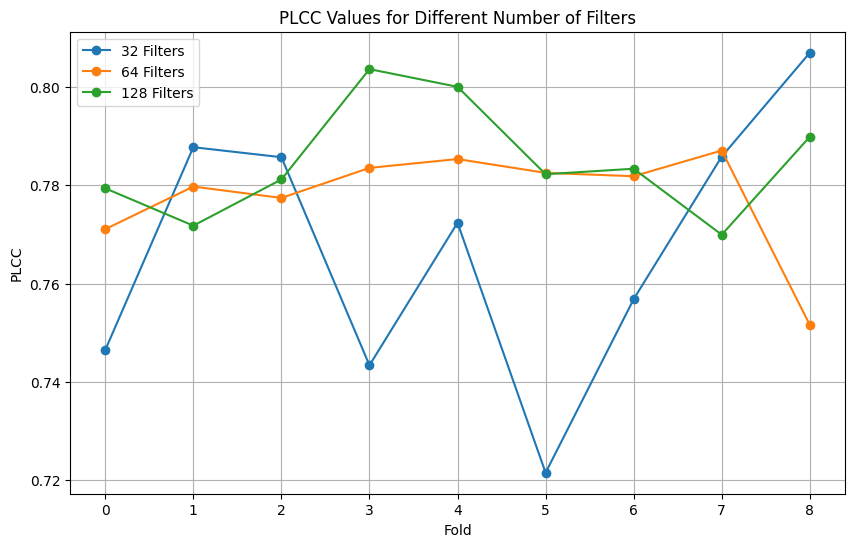

In [ ]:
import matplotlib.pyplot as plt

# PLCC values for different filter settings
plcc_32_filters = [0.7464490868128097, 0.787780994939151, 0.785741357781719, 0.7433311998042488, 0.772383632227643, 0.7214371588832272, 0.7568117065769596, 0.7858683592278131, 0.8070374770067986]
plcc_64_filters = [0.771077944526609, 0.7797597749209718, 0.7774387978485691, 0.7835669384630506, 0.7853655371717253, 0.7825475845460298, 0.7818697802532548, 0.7871055281033801, 0.7515611003739538]
plcc_128_filters = [0.7794046036112581, 0.7717870107925738, 0.7812036828846705, 0.8036928392493314, 0.8000906463442915, 0.7822758477697672, 0.7833948716849051, 0.7699424345662024, 0.7899124701742212]

# Plotting the PLCC values
plt.figure(figsize=(10, 6))
plt.plot(plcc_32_filters, label='32 Filters', marker='o')
plt.plot(plcc_64_filters, label='64 Filters', marker='o')
plt.plot(plcc_128_filters, label='128 Filters', marker='o')

# Adding titles and labels
plt.title('PLCC Values for Different Number of Filters')
plt.xlabel('Fold')
plt.ylabel('PLCC')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


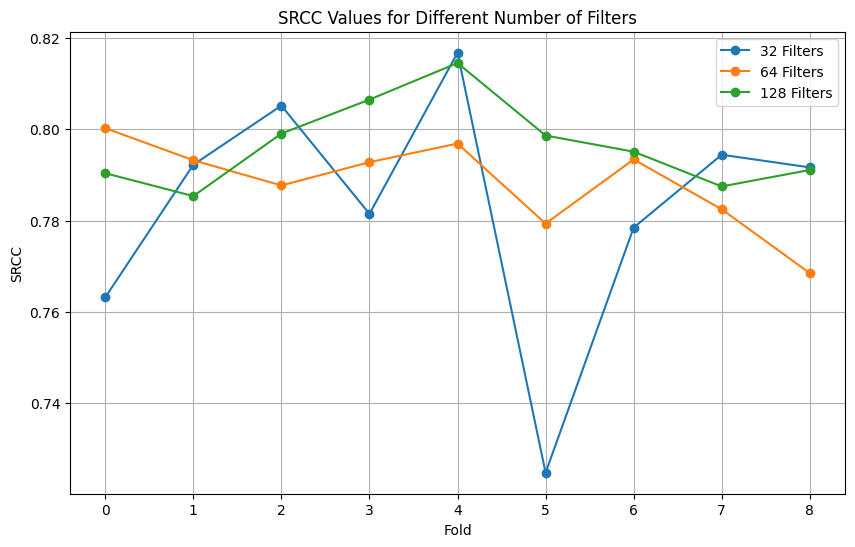

In [ ]:
import matplotlib.pyplot as plt

# SRCC values for different filter settings
srcc_32_filters = [0.7631994539058105, 0.7922447589099398, 0.8051916665172436, 0.7814765858779501, 0.8167790986313148, 0.7247822383851682, 0.7784785375007617, 0.7944324228434277, 0.7916594032297851]
srcc_64_filters = [0.8002577965805375, 0.7932261589393986, 0.7877070310885677, 0.7928029690129275, 0.7968813385840412, 0.7793518586436451, 0.7934059061624797, 0.7824849979682817, 0.7684937952193786]
srcc_128_filters = [0.790390057436723, 0.7853751316182728, 0.7990692841420625, 0.8065151582747903, 0.8145193329805626, 0.7986463145539564, 0.7950987753079503, 0.7874909747294325, 0.7910921711097747]

# Plotting the SRCC values
plt.figure(figsize=(10, 6))
plt.plot(srcc_32_filters, label='32 Filters', marker='o')
plt.plot(srcc_64_filters, label='64 Filters', marker='o')
plt.plot(srcc_128_filters, label='128 Filters', marker='o')

# Adding titles and labels
plt.title('SRCC Values for Different Number of Filters')
plt.xlabel('Fold')
plt.ylabel('SRCC')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


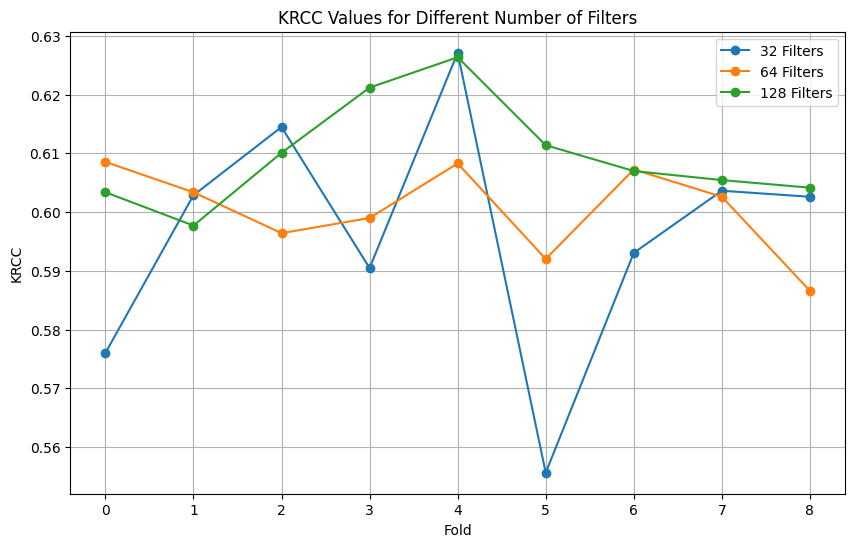

In [ ]:
import matplotlib.pyplot as plt

# KRCC values for different filter settings
krcc_32_filters = [0.5760222400727975, 0.602868613628154, 0.6144836155395611, 0.590478568193148, 0.6271317587936407, 0.5556382128704737, 0.5930616465697423, 0.6036409569127901, 0.6026090156763235]
krcc_64_filters = [0.6085467656477693, 0.6033855593326795, 0.5964158681247668, 0.5989975963818798, 0.6082870176826631, 0.5920292552934485, 0.6072529762603366, 0.602610815835632, 0.5866101011725608]
krcc_128_filters = [0.6033851092928523, 0.5977065072334098, 0.6100947525091072, 0.6211938588089188, 0.6263586654426261, 0.6113877918301615, 0.6069972786536746, 0.6054507919250941, 0.6041573025642126]

# Plotting the KRCC values
plt.figure(figsize=(10, 6))
plt.plot(krcc_32_filters, label='32 Filters', marker='o')
plt.plot(krcc_64_filters, label='64 Filters', marker='o')
plt.plot(krcc_128_filters, label='128 Filters', marker='o')

# Adding titles and labels
plt.title('KRCC Values for Different Number of Filters')
plt.xlabel('Fold')
plt.ylabel('KRCC')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import tensorflow as tf
from tensorflow.keras import layers, models

name_list = ['bag', 'banana', 'biscuits', 'cake', 'cauliflower', 'flowerpot', 'glasses_case', 'honeydew_melon',
             'house', 'litchi', 'mushroom', 'pen_container', 'pineapple', 'ping-pong_bat', 'puer_tea', 'pumpkin',
             'ship', 'statue', 'stone', 'tool_box']

# get data according to the train test name lists, return scaled train and test set
def get_data(train_name_list, test_name_list):
    feature_data = pd.read_csv("/content/feature-wpc.csv", index_col=0, keep_default_na=False)
    feature_data = feature_data[feature_data.columns.values]
    score_data = pd.read_csv("/content/mos-wpc.csv")
    mos = score_data['mos'].tolist()
    total_obj_names = score_data['name']
    score_data = pd.read_csv("/content/mos-wpc.csv", index_col=0)
    train_set = []
    train_score = []
    test_set = []
    test_score = []

    for name in train_name_list:
        obj_names = []
        for obj in total_obj_names:
            if name in obj:
                obj_names.append(obj)
        for i in obj_names:
            data = feature_data.loc[i, :].tolist()
            train_set.append(data)
            train_score.append(score_data.loc[i, :].tolist()[0])

    for name in test_name_list:
        obj_names = []
        for obj in total_obj_names:
            if name in obj:
                obj_names.append(obj)
        for i in obj_names:
            data = feature_data.loc[i, :].tolist()
            test_set.append(data)
            test_score.append(score_data.loc[i, :].tolist()[0])

    scaler = MinMaxScaler()
    train_set = scaler.fit_transform(train_set)
    test_set = scaler.transform(test_set)

    return np.array(train_set), np.array(train_score) / 100, np.array(test_set), np.array(test_score) / 100


# Define the CNN model
def create_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(1))  # Output layer for regression task
    model.compile(optimizer='adam', loss='mean_squared_error')  # Adjust loss based on your task
    return model


if __name__ == '__main__':
    plcc = []
    srcc = []
    krcc = []

    for i in range(5):
        # generate 5 folder cross-validation split name lists
        train_name_list = name_list.copy()
        # get test set and remove the test content from the training set
        test_name_list = [train_name_list.pop(4 * i + 3), train_name_list.pop(4 * i + 2),
                          train_name_list.pop(4 * i + 1), train_name_list.pop(4 * i)]
        print('Begin split ' + str(i + 1) + ' and use the following list as a test set:')
        print(test_name_list)
        # get the data according to the name lists
        train_set, train_score, test_set, test_score = get_data(train_name_list, test_name_list)
        # begin training and predicting
        print('Begin training!')
        cnn_model = create_cnn_model(input_shape=(train_set.shape[1], 1))
        cnn_model.fit(train_set, train_score, epochs=10, batch_size=32, verbose=1)

        # Predict scores using CNN
        predict_score = cnn_model.predict(test_set).flatten()

        # record the result
        plcc.append(stats.pearsonr(predict_score, test_score)[0])
        srcc.append(stats.spearmanr(predict_score, test_score)[0])
        krcc.append(stats.stats.kendalltau(predict_score, test_score)[0])

        print('Training complete!')
        print('------------------------------------------------------------------------------------------------------------------')

    print('------------------------------------------------------------------------------------------------------------------')
    print('Final Results presentation:')
    print("SRCC:  " + str(sum(srcc) / len(srcc)))
    print("PLCC:  " + str(sum(plcc) / len(plcc)))
    print("KRCC:  " + str(sum(krcc) / len(krcc)))

Begin split 1 and use the following list as a test set:
['cake', 'biscuits', 'banana', 'bag']
Begin training!
Epoch 1/10
19/19 [==============================] - 1s 11ms/step - loss: 0.0901
Epoch 2/10
19/19 [==============================] - 0s 8ms/step - loss: 0.0484
Epoch 3/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0427
Epoch 4/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0376
Epoch 5/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0352
Epoch 6/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0343
Epoch 7/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0338
Epoch 8/10
19/19 [==============================] - 0s 7ms/step - loss: 0.0333
Epoch 9/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0321
Epoch 10/10
5/5 [==============================] - 0s 3ms/step
Training complete!
------------------------------------------------------------------------------------------------

<ipython-input-8-cc6902ddf4d1>:91: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
19/19 [==============================] - 1s 6ms/step - loss: 0.0864
Epoch 2/10
19/19 [==============================] - 0s 5ms/step - loss: 0.0470
Epoch 3/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0439
Epoch 4/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0379
Epoch 5/10
19/19 [==============================] - 0s 7ms/step - loss: 0.0350
Epoch 6/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0348
Epoch 7/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0326
Epoch 8/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0330
Epoch 9/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0316
Epoch 10/10
5/5 [==============================] - 0s 3ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 3 and use the following list as a test set:
['pen_container', 'mushroom', 'litch

<ipython-input-8-cc6902ddf4d1>:91: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc.append(stats.stats.kendalltau(predict_score, test_score)[0])


Begin training!
Epoch 1/10
19/19 [==============================] - 1s 6ms/step - loss: 0.0857
Epoch 2/10
19/19 [==============================] - 0s 7ms/step - loss: 0.0478
Epoch 3/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0406
Epoch 4/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0376
Epoch 5/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0355
Epoch 6/10
19/19 [==============================] - 0s 5ms/step - loss: 0.0342
Epoch 7/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0322
Epoch 8/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0313
Epoch 9/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0306
Epoch 10/10
5/5 [==============================] - 0s 3ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 4 and use the following list as a test set:
['pumpkin', 'puer_te

<ipython-input-8-cc6902ddf4d1>:91: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc.append(stats.stats.kendalltau(predict_score, test_score)[0])


Begin training!
Epoch 1/10
19/19 [==============================] - 1s 6ms/step - loss: 0.0844
Epoch 2/10
19/19 [==============================] - 0s 5ms/step - loss: 0.0487
Epoch 3/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0469
Epoch 4/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0410
Epoch 5/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0380
Epoch 6/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0352
Epoch 7/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0339
Epoch 8/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0329
Epoch 9/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0317
Epoch 10/10
5/5 [==============================] - 0s 3ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
Begin split 5 and use the following list as a test set:
['tool_box', 'stone'

<ipython-input-8-cc6902ddf4d1>:91: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc.append(stats.stats.kendalltau(predict_score, test_score)[0])


Epoch 1/10
19/19 [==============================] - 1s 5ms/step - loss: 0.0822
Epoch 2/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0457
Epoch 3/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0399
Epoch 4/10
19/19 [==============================] - 0s 6ms/step - loss: 0.0404
Epoch 5/10
19/19 [==============================] - 0s 7ms/step - loss: 0.0333
Epoch 6/10
19/19 [==============================] - 0s 9ms/step - loss: 0.0343
Epoch 7/10
19/19 [==============================] - 0s 10ms/step - loss: 0.0339
Epoch 8/10
19/19 [==============================] - 0s 10ms/step - loss: 0.0300
Epoch 9/10
19/19 [==============================] - 0s 10ms/step - loss: 0.0354
Epoch 10/10
5/5 [==============================] - 0s 4ms/step
Training complete!
------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------

<ipython-input-8-cc6902ddf4d1>:91: DeprecationWarning: Please use `kendalltau` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  krcc.append(stats.stats.kendalltau(predict_score, test_score)[0])
